### CREDIT

This notebook is prepared by the guidance of Jesús Martínez's book, which is Tensorflow 2.0 Computer Vision Cookbook. Most of the code blocks and explanations are taken from this book. You can reach original codes and detailed explanations from book or from github repo of the book (https://github.com/PacktPublishing/Tensorflow-2.0-Computer-Vision-Cookbook).


#### WHAT IS THIS NOTEBOOK

This notebook is an example about developing a special DCGAN architecture to train a classifier on a very
small subset of Fashion-MNIST by keras and TF.

You can check book for details (Chapter 6, recipe-2)

#### Keywords

* DCGAN
* Semi-Supervised Learning
* GAN
* TF
* Fashion-MNIST dataset

In [1]:
import numpy as np
from numpy.random import randint
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import fashion_mnist as fmnist
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

function to pick a subset of the data. This will allow us to simulate a situation of scarce data, a perfect fit for semisupervised
learning

In [2]:
def pick_supervised_subset(feats,labels,n_samples=1000,n_classes=10):
    
    samples_per_class = int(n_samples / n_classes)

    X = []
    y = []
    for i in range(n_classes):
        class_feats = feats[labels == i]
        class_sample_idx = randint(low=0,
                                   high=len(class_feats),
                                   size=samples_per_class)

        X.extend([class_feats[j] for j in class_sample_idx])
        y.extend([i] * samples_per_class)

    return np.array(X), np.array(y)

a function to select a random sample of data for classification. This
means that we'll use the labels from the original dataset

In [3]:
def pick_samples_for_classification(feats, labels, n_samples):
    sample_idx = randint(low=0,
                         high=feats.shape[0],
                         size=n_samples)

    X = np.array([feats[i] for i in sample_idx])
    y = np.array([labels[i] for i in sample_idx])

    return X, y

function in order
to select a random sample for discrimination. The main difference with the last
function is that the labels here are all 1, indicating that all images are real

In [4]:
def pick_samples_for_discrimination(feats, n_samples):
    sample_idx = randint(low=0,
                         high=feats.shape[0],
                         size=n_samples)

    X = np.array([feats[i] for i in sample_idx])
    y = np.ones((n_samples, 1))

    return X, y

In [5]:
def generate_latent_points(latent_size, n_samples):
    z_input = np.random.randn(latent_size * n_samples)
    z_input = z_input.reshape(n_samples, latent_size)
    return z_input


def generate_fake_samples(model, latent_size, n_samples):
    z_input = generate_latent_points(latent_size, n_samples)
    images = model.predict(z_input)
    y = np.zeros((n_samples, 1))
    return images, y

In [6]:
class SSGAN(object):
    def __init__(self,
                 latent_size=100,
                 input_shape=(28, 28, 1),
                 alpha=0.2):
        self.latent_size = latent_size
        self.input_shape = input_shape
        self.alpha = alpha

        (self.classifier,
         self.discriminator) = self._create_discriminators()

        clf_opt = Adam(learning_rate=2e-4, beta_1=0.5)
        self.classifier.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=clf_opt,
            metrics=['accuracy'])

        dis_opt = Adam(learning_rate=2e-4, beta_1=0.5)
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=dis_opt)

        self.generator = self._create_generator()

        self.gan = self._create_gan()
        gan_opt = Adam(learning_rate=2e-4, beta_1=0.5)
        self.gan.compile(loss='binary_crossentropy',
                         optimizer=gan_opt)

    def _create_discriminators(self, num_classes=10):
        def custom_activation(x):
            log_exp_sum = K.sum(K.exp(x), axis=-1,
                                keepdims=True)
            return log_exp_sum / (log_exp_sum + 1.0)

        input = Input(shape=self.input_shape)
        x = input

        for _ in range(3):
            x = Conv2D(filters=128,
                       kernel_size=(3, 3),
                       strides=2,
                       padding='same')(x)
            x = LeakyReLU(alpha=self.alpha)(x)

        x = Flatten()(x)
        x = Dropout(rate=0.4)(x)
        x = Dense(units=num_classes)(x)
        clf_output = Softmax()(x)
        clf_model = Model(input, clf_output)

        dis_output = Lambda(custom_activation)(x)
        discriminator_model = Model(input, dis_output)

        return clf_model, discriminator_model

    def _create_generator(self):
        input = Input(shape=(self.latent_size,))

        x = Dense(units=128 * 7 * 7)(input)
        x = LeakyReLU(alpha=self.alpha)(x)
        x = Reshape((7, 7, 128))(x)

        for _ in range(2):
            x = Conv2DTranspose(filters=128,
                                kernel_size=(4, 4),
                                strides=2,
                                padding='same')(x)
            x = LeakyReLU(alpha=self.alpha)(x)

        x = Conv2D(filters=1,
                   kernel_size=(7, 7),
                   padding='same')(x)
        output = Activation('tanh')(x)

        return Model(input, output)

    def _create_gan(self):
        self.discriminator.trainable = False
        output = self.discriminator(self.generator.output)

        return Model(self.generator.input, output)

    def train(self, X, y, epochs=20, num_batches=100):
        X_sup, y_sup = pick_supervised_subset(X, y)

        batches_per_epoch = int(X.shape[0] / num_batches)
        num_steps = batches_per_epoch * epochs
        num_samples = int(num_batches / 2)

        for _ in tqdm(range(num_steps)):
            X_sup_real, y_sup_real = \
                pick_samples_for_classification(X_sup,
                                                y_sup,
                                                num_samples)
            self.classifier.train_on_batch(X_sup_real,
                                           y_sup_real)

            X_real, y_real = \
                pick_samples_for_discrimination(X,
                                                num_samples)
            self.discriminator.train_on_batch(X_real, y_real)

            X_fake, y_fake = \
                generate_fake_samples(self.generator,
                                      self.latent_size,
                                      num_samples)
            self.discriminator.train_on_batch(X_fake, y_fake)

            X_gan = generate_latent_points(self.latent_size,
                                           num_batches)
            y_gan = np.ones((num_batches, 1))
            self.gan.train_on_batch(X_gan, y_gan)



In [7]:
(X_train, y_train), (X_test, y_test) = fmnist.load_data()
X_train = np.expand_dims(X_train, axis=-1)
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

X_test = np.expand_dims(X_test, axis=-1)
X_test = (X_test.astype(np.float32) - 127.5) / 127.5


In [8]:
ssgan = SSGAN()
ssgan.train(X_train, y_train, epochs=30)

100%|██████████| 18000/18000 [35:48<00:00,  8.38it/s]


In [9]:
train_accuracy = ssgan.classifier.evaluate(X_train, y_train)[1]
train_accuracy *= 100
print(f'Train accuracy: {train_accuracy:.2f}%')

test_accuracy = ssgan.classifier.evaluate(X_test, y_test)[1]
test_accuracy *= 100
print(f'Test accuracy: {test_accuracy:.2f}%')


1875/1875 [==============================] - 6s 3ms/step - loss: 0.5311 - accuracy: 0.8288
Train accuracy: 82.88%
313/313 [==============================] - 1s 4ms/step - loss: 0.5659 - accuracy: 0.8186
Test accuracy: 81.86%


In [10]:
ssgan.classifier.save('ssgan_classifier.h5')

In [12]:
ssgan.discriminator.save('ssgan_discriminator.h5')

In [13]:
ssgan.generator.save('ssgan_generator.h5')

In [14]:
ssgan.gan.save('ssgan_gan.h5')

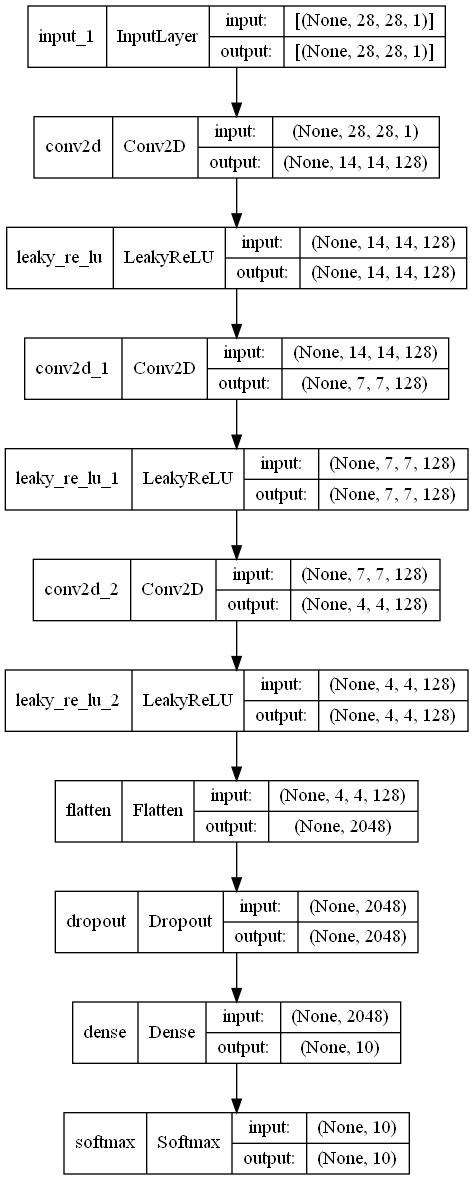

In [28]:
from tensorflow.keras.utils import plot_model
plot_model(ssgan.classifier, show_shapes=True, show_layer_names=True, to_file='ssgan.classifier_fasMNIST.jpg')

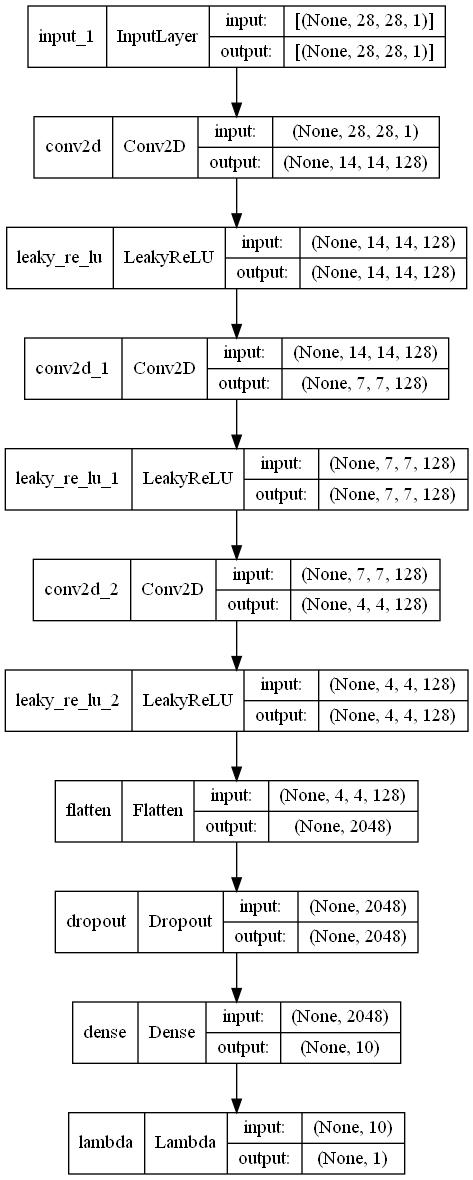

In [29]:
plot_model(ssgan.discriminator, show_shapes=True, show_layer_names=True, to_file='ssgan_discriminator_fasMNIST.jpg')

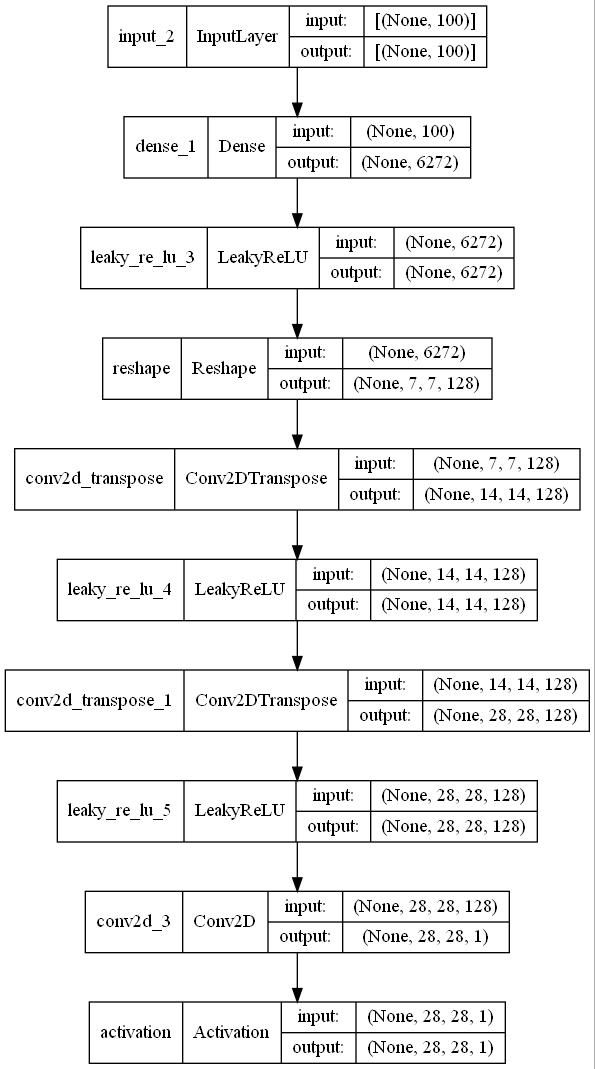

In [30]:
plot_model(ssgan.generator, show_shapes=True, show_layer_names=True, to_file='ssgan_generator_fasMNIST.jpg')

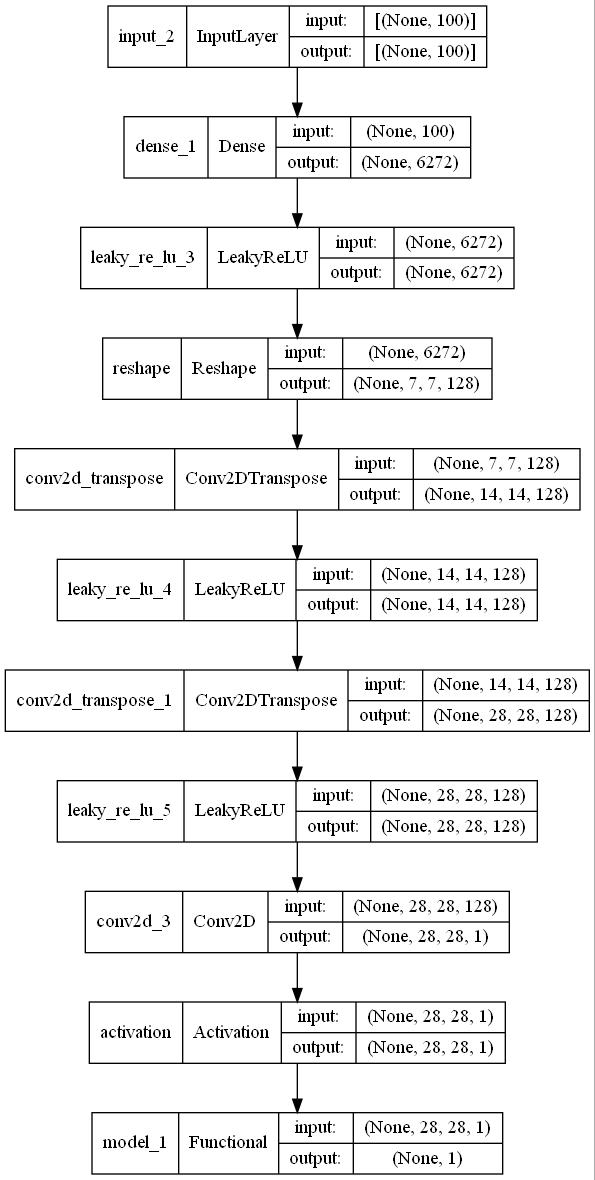

In [31]:
plot_model(ssgan.gan, show_shapes=True, show_layer_names=True, to_file='ssgan_gan_fasMNIST.jpg')

### TESTS

In [15]:
img,test_y=generate_fake_samples(ssgan.generator, 100, 2)

In [17]:
img[0].shape

(28, 28, 1)

In [19]:
test_y

array([[0.],
       [0.]])

In [21]:
real_2=ssgan.discriminator.predict(img)

In [22]:
real

array([[0.34747902],
       [0.20911166]], dtype=float32)

In [23]:
real_2=ssgan.classifier.predict(img)

In [24]:
real_2

array([[1.6418773e-03, 1.3226351e-05, 1.9486481e-04, 9.9709344e-01,
        4.2832847e-04, 1.0461398e-05, 5.9380982e-04, 1.3001479e-05,
        5.9590565e-07, 1.0479711e-05],
       [2.1019866e-04, 9.0230895e-07, 6.4309907e-01, 1.8968998e-04,
        3.2112319e-02, 2.0484395e-06, 3.2432872e-01, 6.4346677e-06,
        3.7623824e-06, 4.6836405e-05]], dtype=float32)

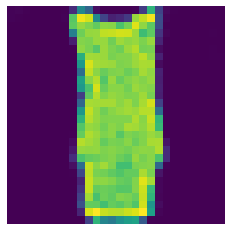

In [26]:
from matplotlib import pyplot as plt
# Visualize 1 random image from the training dataset
plt.axis("off")
plt.imshow(img[0])
plt.show()

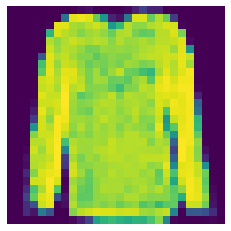

In [27]:
plt.axis("off")
plt.imshow(img[1])
plt.show()

When you check the maxarg of each array... one of the index is 4 and the other one is 3..

Predictions are correct...
 
 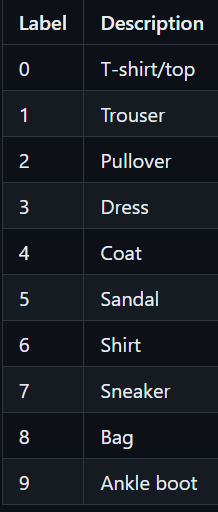